In [17]:
import numpy as np
from scipy.special import expit
from scipy.stats import binom
from matplotlib import pyplot as plt
%matplotlib inline

# Part C

In [18]:
def g(xi, yi, mi, b):
    '''
    This function returns the gradient g_i(beta) calculated from a single sample
    point. 
    
    Inputs:
    xi: an array of shape P, a single sample from the set X of samples
    yi: a float, the number of successes corresponding to the sample xi
    mi: a float, the number of trials corresponding to the sample xi
    b: an array of shape P, a vector representing the current guess for our minimizer
       (beta) of the negative log-likelihood function.
    
    Outputs:
    grad: a vector that represents the gradient approximation at a single sample
        for the negative log-likelihood
    '''
    x_Tb = np.dot(xi, b)
    
    # Take the inverse logit function for x_i^Tb.
    wi = expit(x_Tb)    
    grad = (mi * wi - yi) * xi
    return grad
    
    
    

In [19]:
def negll(X, y, m, beta):
    '''
    This function computes the negative log likelihood given features X, successes y,
    trials m and solution vector beta.
    '''
    Xbeta = np.dot(X, beta)
    w = expit(Xbeta)
    # Use scipy's binomial object to compute the log of the pmf, then take the sum   
    return -binom.logpmf(y, m, w).sum()

In [20]:
def stochgd(X, y, m, b, stepsize=1e-4, iters=10, tol=1e-3):
    '''
    This function implements the stochastic gradient descent algorithm for 
    minimizing the negative log-likelihood using a constant step size.
    
    Inputs:
    X: An N x P array of samples
    y: An N array of the number  of successes for each sample (here, only 1's or 0's)
    m: An N array of the number of trials for each sample (here, an array of ones)
    b: A P array that is the initial guess for the minimizer of the negative log-likelihood
        (initial beta).
    stepsize: A float indicating the constant step size to take in the approximated gradient 
        direction for b.
    iters: The maximum number of times to iterate through the entire set of samples
    
    Outputs:
    b0: The final beta of the algorithm. If the algorithm converges, this should be the 
        minimizer for the negative log-likelihood
    betas: A list of the beta (b) values updated throughout the algorithm
    ll: A list of the negative log-likelihoods for each beta throughout the algorithm
    '''
    b0 = b
    betas = []
    ll = []
    
    N, P = X.shape
    index = np.arange(N)
    for k in np.arange(iters):
        # Randomly shuffle the row index to select samples for the stochastic gradient method
        np.random.shuffle(index)
        for i in index:
            betas.append(b0) # Store the current beta value.
            grad = g(X[i], y[i], m[i], b0) # Take the approximate gradient.
            b1 = b0 - stepsize * grad # Calculate the next beta
            
            llb0 = negll(X, y, m, b0)
            llb1 = negll(X, y, m, b1)
            ll.append(llb0) # Store the current log likelihood value
            if np.abs(llb0 - llb1).sum() > tol:
                b0 = b1 # Update the beta value
            else:
                betas.append(b1) 
                ll.append(llb1)
                return b1, betas, ll
    return b1, betas, ll

In [21]:

N, P = 500, 11
X = np.random.rand(N, P) # Random set of 500 samples
y = (np.random.rand(N) > .5).astype(float) # Random vector of ones and zeros.
m = np.ones(N)
b = np.random.rand(P)


In [22]:
b1, betas, ll = stochgd(X, y, m, b, stepsize=.005, iters=10)

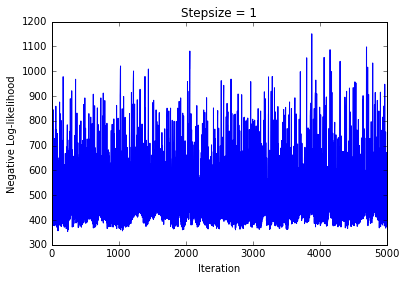

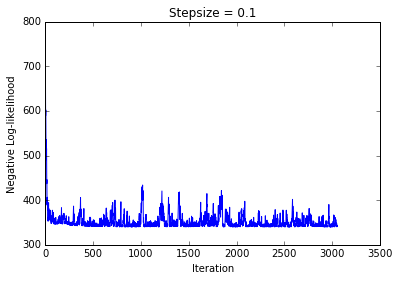

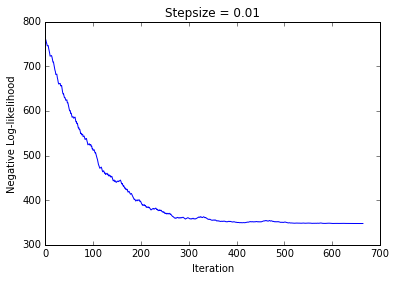

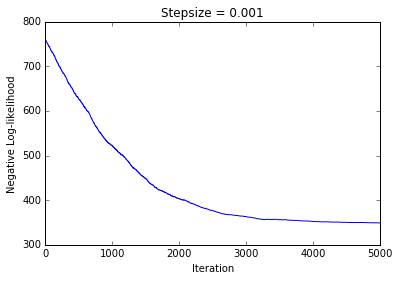

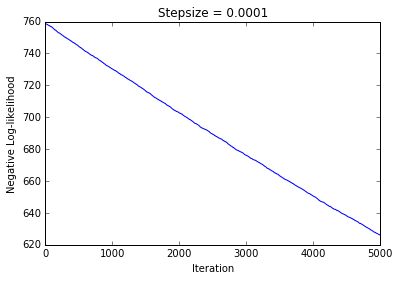

In [23]:
for i in [1, .1, .01, .001, .0001]:
    b1, betas, ll = stochgd(X, y, m, b, stepsize=i, iters=10)
    plt.plot(ll)
    plt.title("Stepsize = " + str(i))
    plt.xlabel("Iteration")
    plt.ylabel("Negative Log-likelihood")
    plt.show()

# Part D

In [36]:
def rm_sgd(X, y, m, b, C=.5, a=.75, iters=10, tol=1e-3):
    '''
    This function implements the stochastic gradient descent algorithm for 
    minimizing the negative log-likelihood using the Robbins-Monro rule for step sizes
    
    Inputs:
    X: An N x P array of samples
    y: An N array of the number  of successes for each sample (here, only 1's or 0's)
    m: An N array of the number of trials for each sample (here, an array of ones)
    b: A P array that is the initial guess for the minimizer of the negative log-likelihood
        (initial beta).
    C: A positive float used to calculate step size
    a: A float such that .5 <= a <= 1, also used to calculate step size.
    iters: The maximum number of times to iterate through the entire set of samples
    
    Outputs:
    b0: The final beta of the algorithm. If the algorithm converges, this should be the 
        minimizer for the negative log-likelihood
    betas: A list of the beta (b) values updated throughout the algorithm
    ll: A list of the negative log-likelihoods for each beta throughout the algorithm
    '''
    b0 = b
    betas = []
    ll = []
    
    N, P = X.shape
    index = np.arange(N)
    t0 = 1
    for k in np.arange(iters):
        # Randomly shuffle the row index to select samples for the stochastic gradient method
        np.random.shuffle(index)
        for j in np.arange(N):
            i = index[j]
            stepsize = C * (j + t0)**(-a)
            
            betas.append(b0) # Store the current beta value.
            grad = g(X[i], y[i], m[i], b0) # Take the approximate gradient.
            b1 = b0 - stepsize * grad 
            
            llb0 = negll(X, y, m, b0)
            llb1 = negll(X, y, m, b1)
            ll.append(llb0) # Store the current log likelihood value
            if np.abs(llb0 - llb1).sum() > tol: # Check for convergence (based on -log-liklihood)
                b0 = b1 # Update the beta value
            else:
                betas.append(b1) 
                ll.append(llb1)
                return b1, betas, ll
    return b1, betas, ll

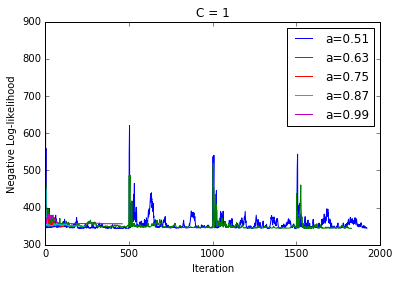

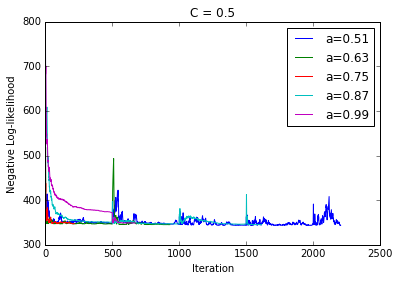

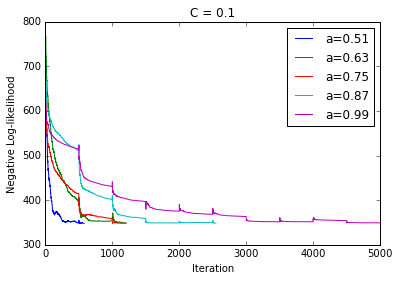

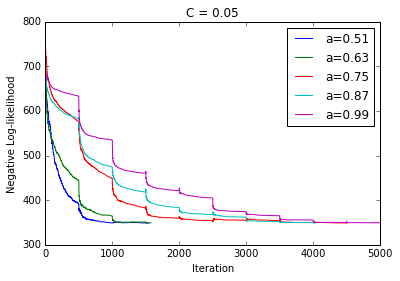

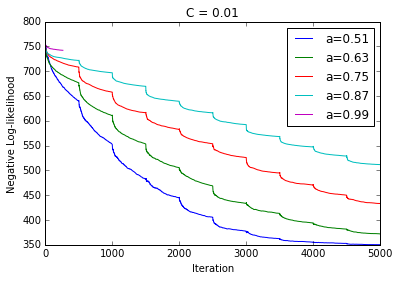

In [37]:
N, P = 500, 11
X = np.random.rand(N, P) # Random set of 500 samples
y = (np.random.rand(N) > .5).astype(float) # Random vector of ones and zeros.
m = np.ones(N)
b = np.random.rand(P)

for i in [1, .5, .1, .05, .01]:
    for j in np.linspace(.51, .99, 5):
        b1, betas, ll = rm_sgd(X, y, m, b, C=i, a=j, iters=10)
        plt.plot(ll, label="a="+str(j))
    plt.title("C = " + str(i))
    plt.xlabel("Iteration")
    plt.ylabel("Negative Log-likelihood")
    plt.legend(loc='best')
    plt.show()

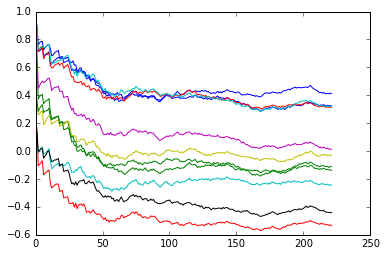

In [38]:
# This code demonstrates what happens to the beta values over time
N, P = 500, 11
X = np.random.rand(N, P) # Random set of 500 samples
y = (np.random.rand(N) > .5).astype(float) # Random vector of ones and zeros.
m = np.ones(N)
b = np.random.rand(P)
b1, betas, ll = rm_sgd(X, y, m, b, C=.5, a=.63, iters=10)
plt.plot(betas)
plt.show()